<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-A01228409-ErnestoER/blob/main/semana8/A01228409_TecMty_kmeans_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Actividad Semanal -- 7 Regresiones y K means**

**Ernesto Enriquez Rubio**

**A01228409**

**Ciencia y analítica de datos**

**María de la Paz Rico Fernández**

**09 de Noviembre del 2022**

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [ ]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

In [345]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [346]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [347]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [348]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [349]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

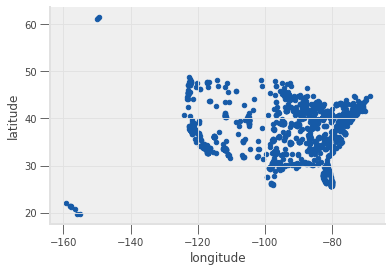

In [350]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [351]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [352]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [353]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [354]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [355]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [356]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

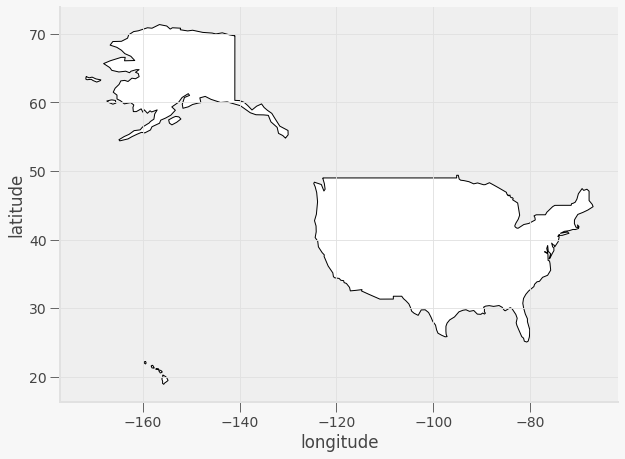

In [357]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

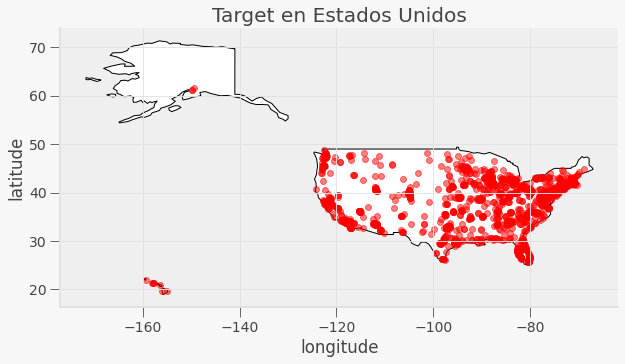

In [358]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

In [359]:
#Librerías a utilizar
from sklearn.cluster import KMeans
# import module
from geopy.geocoders import Nominatim

In [360]:
#Se crea variable con latitud y longitud
X_latlong = df[['latitude','longitude']].copy()

**Realizamos la busqueda de la mejor cantidad de almacenes para cubrir las zonas requeridad.**

In [361]:
# Funciones para graficar los grupos de Kmean
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    X=X.to_numpy()
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [362]:
# Creamos diferentes modelos de KMean con diferentes clusters.
kmeans_per_k = [KMeans(n_clusters=k).fit(X_latlong)
                for k in range(1, 121, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [363]:
inertias

[527995.4430694166,
 19423.442747935256,
 6332.78103024288,
 3591.2028724773472,
 2432.6158115739618,
 1758.5213812812158,
 1346.7218696500697,
 1085.134228906769,
 880.6754881410449,
 725.023787375286,
 632.4410001523227,
 539.8416632391359]

**Graficamos los resultados de la inercia con diferentes clusters para determinar cual es el codo de la gráfica.**

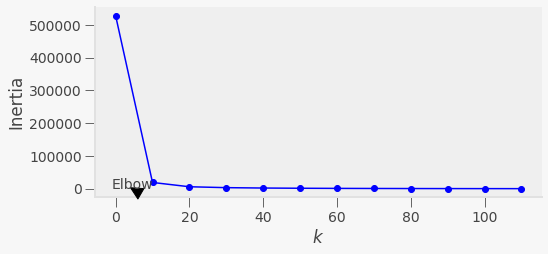

In [364]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(0, 120, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(4.5, 650, "Elbow", horizontalalignment="center")
plt.grid()
plt.show()

**El codo se encuentra en los 10 clusters, no obstante es después de los 20 que no hay mucha diferencia.**

In [365]:
kmeans_per_k

[KMeans(n_clusters=1),
 KMeans(n_clusters=11),
 KMeans(n_clusters=21),
 KMeans(n_clusters=31),
 KMeans(n_clusters=41),
 KMeans(n_clusters=51),
 KMeans(n_clusters=61),
 KMeans(n_clusters=71),
 KMeans(n_clusters=81),
 KMeans(n_clusters=91),
 KMeans(n_clusters=101),
 KMeans(n_clusters=111)]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



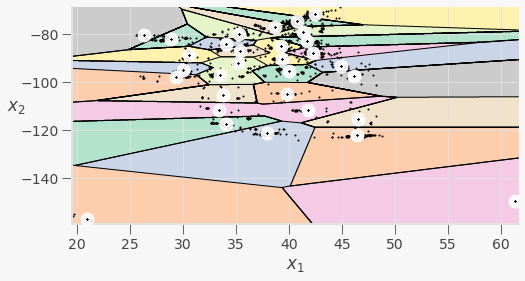

In [366]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_per_k[3], X_latlong)
plt.show()

**Revisamos la métrica de silhouette para observar que tan separado estan nuestros clusters de los elementos dentro de ellos y entre ellos para determinar si 20 clusters es lo ideal.**

In [367]:
from sklearn.metrics import silhouette_score

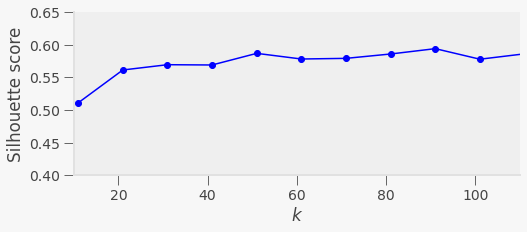

In [368]:
silhouette_scores = [silhouette_score(X_latlong, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(11, 121, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([10, 110, 0.40, 0.65])
plt.grid()
plt.show()

**Después de analizar los valores del Silhouette, podemos ver que después de los 50, no hay una mejora considerable, es por eso que determinamos que los clusters para este problema son 50.**

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



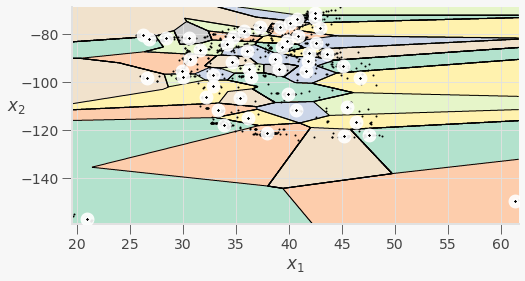

In [380]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_per_k[5], X_latlong)
plt.show()

In [370]:
#Se establece el modelo con el número óptimo de clusters
modelo_optimo = KMeans(n_clusters = 50)

#Se entrena al modelo
modelo_optimo.fit(X_latlong)

#Ubicación de almacenes
almacenes_latlong = modelo_optimo.cluster_centers_

#Se crea un dataframe de pandas con las coordenadas de los centros
df_almacenes_latlong = pd.DataFrame(almacenes_latlong, columns = ['latitude','longitude'])

#Se crea una nueva columna con las coordenadas combinadas
df_almacenes_latlong["Coordinates"] = list(zip(df_almacenes_latlong.longitude, df_almacenes_latlong.latitude))

#Se formatea la columna como un punto
df_almacenes_latlong["Coordinates"] = df_almacenes_latlong["Coordinates"].apply(Point)

#Se despliega encabezado
df_almacenes_latlong.head()

,latitude,longitude,Coordinates
0,31.688884,-86.282318,POINT (-86.28231806296296 31.688884444444447)
1,33.294533,-111.848215,POINT (-111.84821455555554 33.29453293333333)
2,29.991975,-98.033790,POINT (-98.03379005714285 29.991975297142858)
3,42.442846,-73.139616,POINT (-73.13961614482758 42.44284566206897)
4,42.343021,-88.051992,POINT (-88.05199188984375 42.3430206203125)


In [371]:
#Se transforma a Geografic Pandas
gdf_almacenes_latlong = gpd.GeoDataFrame(df_almacenes_latlong, geometry="Coordinates")

#Se despliega encabezado
gdf_almacenes_latlong.head()

,latitude,longitude,Coordinates
0,31.688884,-86.282318,POINT (-86.28232 31.68888)
1,33.294533,-111.848215,POINT (-111.84821 33.29453)
2,29.991975,-98.033790,POINT (-98.03379 29.99198)
3,42.442846,-73.139616,POINT (-73.13962 42.44285)
4,42.343021,-88.051992,POINT (-88.05199 42.34302)


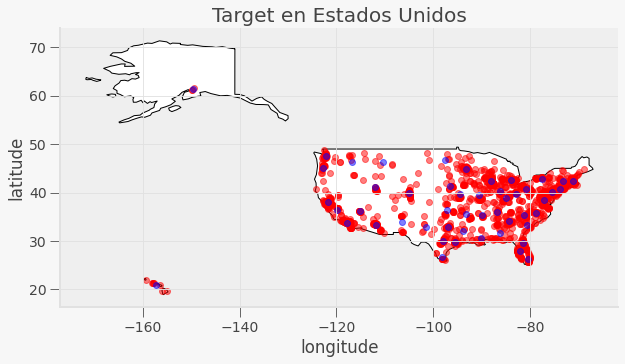

In [372]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

#Coordenadas de los almacenes
gdf_almacenes_latlong.plot(ax=gax, color='blue', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

**Para determinar la cantidad de tiendas que abasteceran cada almacén, hacemos la predicción y realizamos el conteo.**

El número de tiendas por cluster es:
Tiendas por Cluster
4                      128
13                     120
31                     105
23                     100
10                      78
6                       73
5                       70
32                      66
24                      56
38                      53
14                      52
27                      51
9                       49
43                      46
1                       45
29                      43
22                      40
18                      39
2                       35
17                      35
7                       31
8                       31
41                      30
21                      29
3                       29
26                      29
0                       27
37                      27
36                      26
47                      24
44                      23
42                      22
16                      21
48                      19
35                      1

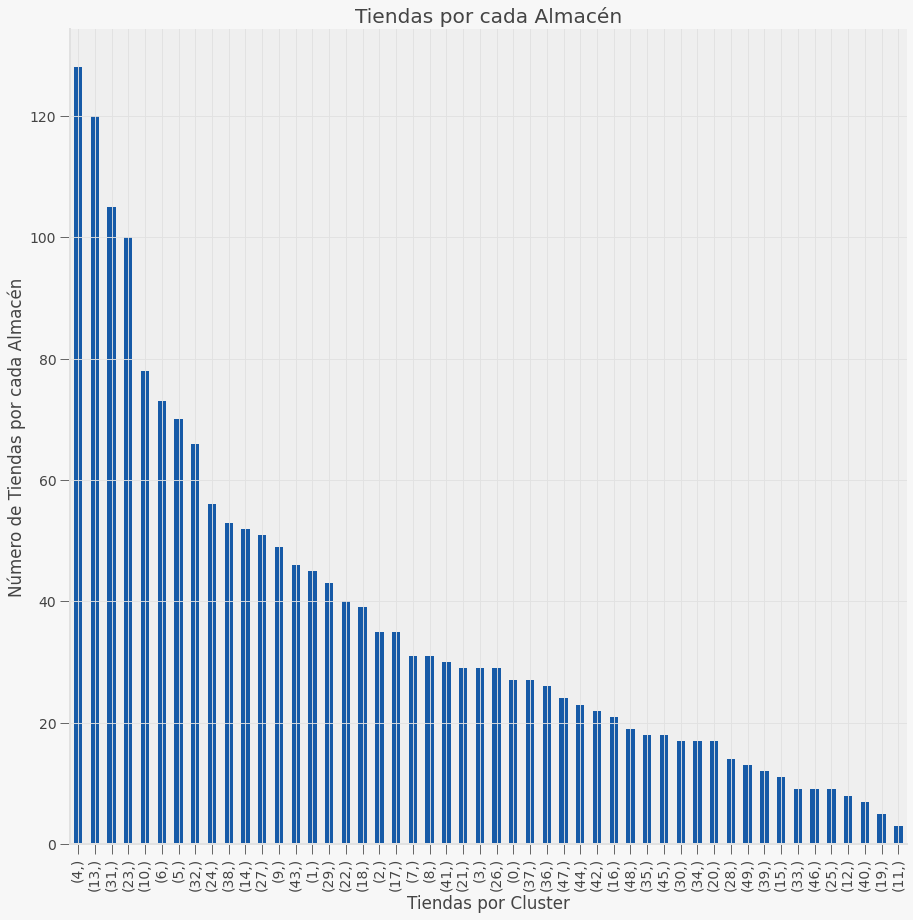

In [373]:
tiendas_por_cluster = modelo_optimo.predict(X_latlong)

df_tiendas_por_cluster = pd.DataFrame(tiendas_por_cluster, columns = ['Tiendas por Cluster'])

print('El número de tiendas por cluster es:\n{}'.format(df_tiendas_por_cluster.value_counts()))

plt.subplots(figsize=(15,15))
plt.title('Tiendas por cada Almacén')
plt.ylabel('Número de Tiendas por cada Almacén')
df_tiendas_por_cluster.value_counts().plot(kind='bar')
plt.show()

**Calculamos las distancias que hay entre los almacenes y cada tienda.**

In [374]:
almacen_city = {'Direccion': list(), 'Almacen': list(), 'Distancia': list()}
for i in range(0, len(X_latlong)):
  predict = modelo_optimo.predict(pd.DataFrame(X_latlong.iloc[i]).T)
  almacen_city['Almacen'].append(f'Almacen{predict[0]}')
  almacen_city['Direccion'].append(df.iloc[i].address)
  loc_alm_1 = f"{gdf_almacenes_latlong['latitude'][predict[0]]}, {gdf_almacenes_latlong['longitude'][predict[0]]}"
  loc_alm_2 = f"{X_latlong.iloc[i].latitude}, {X_latlong.iloc[i].longitude}"
  distancia = geodesic(loc_alm_1, loc_alm_2).kilometers
  almacen_city['Distancia'].append(round(distancia, 2))


**Confirmamos que la cantidad de ciudades corresponde a la que sera abastecida por cada almacén.**

In [375]:
distancias_pd = pd.DataFrame(almacen_city)
distancias_pd['Almacen'].value_counts(sort=True)

Almacen4     128
Almacen13    120
Almacen31    105
Almacen23    100
Almacen10     78
Almacen6      73
Almacen5      70
Almacen32     66
Almacen24     56
Almacen38     53
Almacen14     52
Almacen27     51
Almacen9      49
Almacen43     46
Almacen1      45
Almacen29     43
Almacen22     40
Almacen18     39
Almacen17     35
Almacen2      35
Almacen7      31
Almacen8      31
Almacen41     30
Almacen26     29
Almacen3      29
Almacen21     29
Almacen0      27
Almacen37     27
Almacen36     26
Almacen47     24
Almacen44     23
Almacen42     22
Almacen16     21
Almacen48     19
Almacen45     18
Almacen35     18
Almacen30     17
Almacen34     17
Almacen20     17
Almacen28     14
Almacen49     13
Almacen39     12
Almacen15     11
Almacen46      9
Almacen33      9
Almacen25      9
Almacen12      8
Almacen40      7
Almacen19      5
Almacen11      3
Name: Almacen, dtype: int64

**Teniendo la base de datos de las distancias que existen se puede filtrar para buscar por almacén o por dirreción, o incluso por las distancias más cortas, pendiendo de la necesidad.**

In [376]:
distancias_pd[distancias_pd['Almacen'] == 'Almacen1']

,Direccion,Almacen,Distancia
26,"1650 S Milton Rd, Flagstaff, AZ 86001-0802",Almacen1,210.32
27,"16825 E Shea Blvd, Fountain Hills, AZ 85268-6668",Almacen1,33.20
28,"10555 N Oracle Rd, Oro Valley, AZ 85737-9353",Almacen1,129.52
29,"1851 E Highway 69, Prescott, AZ 86301-5665",Almacen1,149.26
30,"21398 S Ellsworth Loop Rd, Queen Creek, AZ 851...",Almacen1,19.81
31,"4151 E Highway 90, Sierra Vista, AZ 85635-2425",Almacen1,244.11
32,"13731 W Bell Rd, Surprise, AZ 85374-3871",Almacen1,60.41
33,"9830 W Lower Buckeye Rd, Tolleson, AZ 85353-9424",Almacen1,41.74
34,"1450 S Yuma Palms Pkwy, Yuma, AZ 85365-1707",Almacen1,265.89
35,"3425 W Frye Rd, Chandler, AZ 85226-5008",Almacen1,4.78


In [377]:
# initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")

county_list = []
city_list = []
town_list = []
state_list = []
country_list = []
code_list = []
zipcode_list = []
tiendas_cluster_list = []
 
for i in range(0, len(df_almacenes_latlong)):
 
  # Latitude & Longitude input
  Latitude = str(df_almacenes_latlong['latitude'][i])
  Longitude = str(df_almacenes_latlong['longitude'][i])

  location = geolocator.reverse(Latitude+","+Longitude)
 
  address = location.raw['address']
 
  # traverse the data
  county = address.get('county', '')
  city = address.get('city', '')
  town = address.get('town', '')
  state = address.get('state', '')
  country = address.get('country', '')
  code = address.get('country_code')
  zipcode = address.get('postcode')

  county_list.append(county)
  city_list.append(city)
  town_list.append(town)
  state_list.append(state)
  country_list.append(country)
  code_list.append(code)
  zipcode_list.append(zipcode)
  #tiendas_cluster_list.append(tiendas_cluster)

df_almacenes_latlong['County'] = county_list
df_almacenes_latlong['City'] = city_list
df_almacenes_latlong['Town'] = town_list
df_almacenes_latlong['State'] = state_list
df_almacenes_latlong['Country'] = country_list
df_almacenes_latlong['Code'] = code_list
df_almacenes_latlong['Zipcode'] = zipcode_list

tiendas_cluster = modelo_optimo.predict(df_almacenes_latlong[['latitude','longitude']])
tiendas_por_cluster = df_tiendas_por_cluster.value_counts()

df_almacenes_latlong['Cantidad de Tiendas'] = np.ravel(tiendas_por_cluster[tiendas_cluster])

df_almacenes_latlong

,latitude,longitude,Coordinates,County,City,Town,State,Country,Code,Zipcode,Cantidad de Tiendas
0,31.688884,-86.282318,POINT (-86.28232 31.68888),Crenshaw County,,,Alabama,United States,us,36049,27
1,33.294533,-111.848215,POINT (-111.84821 33.29453),Maricopa County,Chandler,,Arizona,United States,us,85224,45
2,29.991975,-98.033790,POINT (-98.03379 29.99198),Hays County,,,Texas,United States,us,78676,35
3,42.442846,-73.139616,POINT (-73.13962 42.44285),Berkshire County,,Hinsdale,Massachusetts,United States,us,01235,29
4,42.343021,-88.051992,POINT (-88.05199 42.34302),Lake County,,Grayslake,Illinois,United States,us,60030,128
5,38.052805,-121.747958,POINT (-121.74796 38.05281),Sacramento County,,,California,United States,us,94571,70
6,40.080377,-75.475079,POINT (-75.47508 40.08038),Chester County,Tredyffrin Township,,Pennsylvania,United States,us,19355,73
7,47.551699,-122.213430,POINT (-122.21343 47.55170),King County,,Mercer Island,Washington,United States,us,98040,31
8,29.483283,-81.509736,POINT (-81.50974 29.48328),Flagler County,,,Florida,United States,us,None,31
9,39.892450,-105.108015,POINT (-105.10802 39.89245),Jefferson County,Westminster,,Colorado,United States,us,80021,49


**Asimismo, revisamos la distancia que existe entre los almacenes, para confirma que no existan almacenes que cubran una distancia mínima.**

In [378]:
from geopy.distance import geodesic

In [390]:
df_to_cal_dist = gdf_almacenes_latlong[['latitude', 'longitude']]
all_dists = []
for i in range(0, 50):
  loc_alm_1 = f"{gdf_almacenes_latlong['latitude'][i]}, {gdf_almacenes_latlong['longitude'][i]}"
  if i == 49:
    loc_alm_2 = f"{gdf_almacenes_latlong['latitude'][0]}, {gdf_almacenes_latlong['longitude'][0]}"
    print(f'Distancia entre Almacén{i+1} y Almacén{1}: {round(distancia, 2)} kms')
    break
  loc_alm_2 = f"{gdf_almacenes_latlong['latitude'][i+1]}, {gdf_almacenes_latlong['longitude'][i+1]}"
  distancia = geodesic(loc_alm_1, loc_alm_2).kilometers
  all_dists.append(round(distancia, 2))
  print(f'Distancia entre Almacén{i+1} y Almacén{i+2}: {round(distancia, 2)} kms')

Distancia entre Almacén1 y Almacén2: 2403.42 kms
Distancia entre Almacén2 y Almacén3: 1359.38 kms
Distancia entre Almacén3 y Almacén4: 2615.27 kms
Distancia entre Almacén4 y Almacén5: 1226.34 kms
Distancia entre Almacén5 y Almacén6: 2888.98 kms
Distancia entre Almacén6 y Almacén7: 3965.62 kms
Distancia entre Almacén7 y Almacén8: 3790.59 kms
Distancia entre Almacén8 y Almacén9: 4013.49 kms
Distancia entre Almacén9 y Almacén10: 2440.55 kms
Distancia entre Almacén10 y Almacén11: 1126.46 kms
Distancia entre Almacén11 y Almacén12: 4037.1 kms
Distancia entre Almacén12 y Almacén13: 4522.5 kms
Distancia entre Almacén13 y Almacén14: 4130.11 kms
Distancia entre Almacén14 y Almacén15: 3344.33 kms
Distancia entre Almacén15 y Almacén16: 991.58 kms
Distancia entre Almacén16 y Almacén17: 670.58 kms
Distancia entre Almacén17 y Almacén18: 1659.64 kms
Distancia entre Almacén18 y Almacén19: 1110.19 kms
Distancia entre Almacén19 y Almacén20: 1777.28 kms
Distancia entre Almacén20 y Almacén21: 590.9 kms
Dis

In [394]:
np.array(all_dists).min()

297.27

**Determinamos que la distancia mínima entre almacenes es de casi 300 km, lo cual es un radio bastante considerable.**

**•	Encuentra las latitudes y longitudes de los almacenes, ¿qué ciudad es?, ¿a cuantas tiendas va surtir?, ¿sabes a que distancia estará?**

**•	¿Cómo elegiste el número de almacenes?, justifica tu respuesta técnicamente.**

Recapitulado, se encontraron las ubicaciones aproximadas de cada almacén incluyendo su latitud y longitud. Asimismo, se graficó la cantidad de tiendas que abastecerá cada almacén y la distancia en la que se encuentra el almacén a la tienda.
Asimismo, el número de almacenes se determino a través de un análisis de KMean con diferentes clusters y buscando disminuir la inercia lo más posible pero evitar proponer almacenes extras, por lo que se busco el punto de inflexión(codo) y a partir de ahí a través de las métricas de silhouettee, se encontró los almacenes mínimos requeridos para cubrir la mayor de las tiendas posibles y que no parezcan reduntantes.

In [384]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Se probaron otras librerías para mostrar gráficamente la ubicación de los almacenes propuestos.**

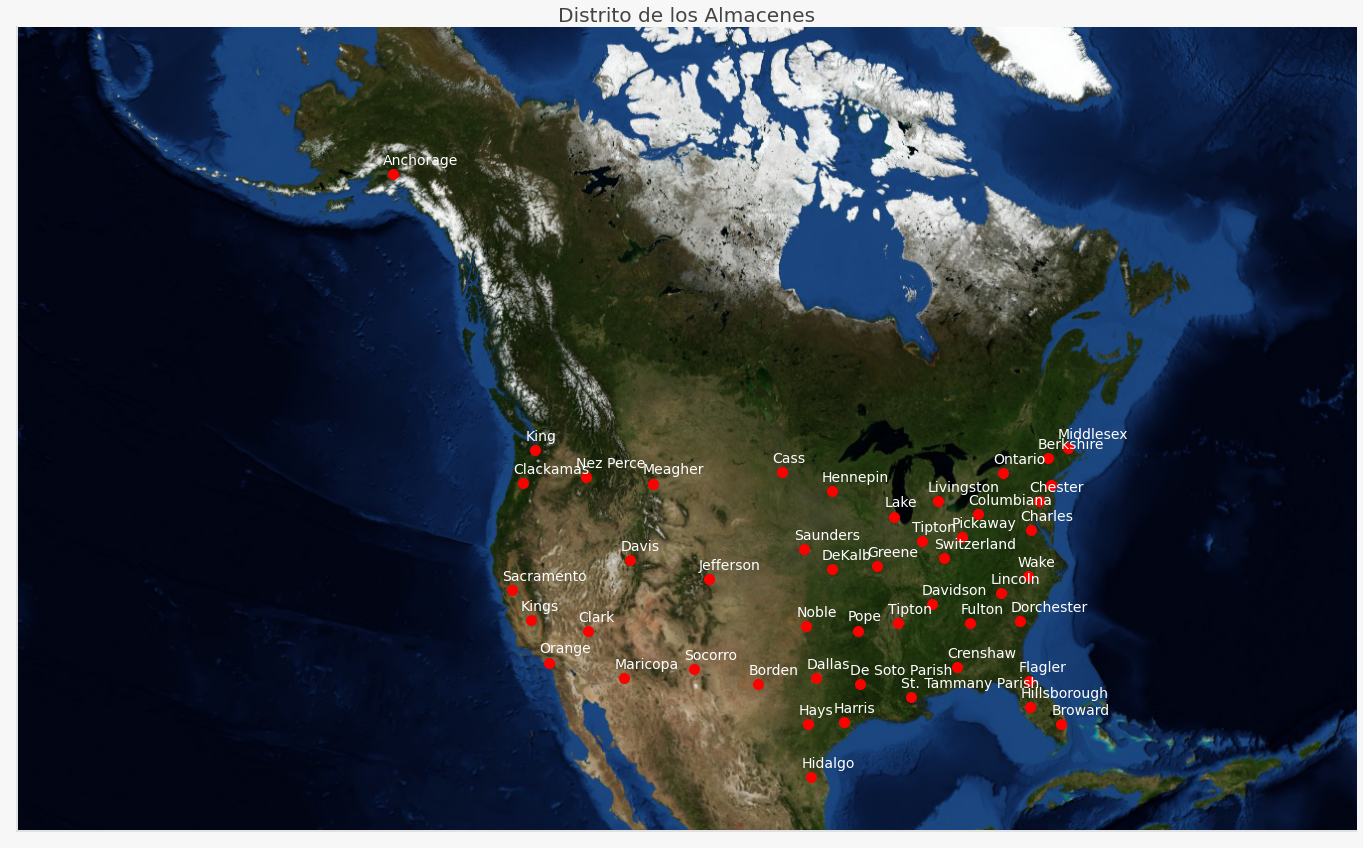

In [385]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math

map = Basemap(width=10000000,height=6000000,projection='lcc',
            resolution=None,lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
plt.figure(num=1, figsize=(24, 20))
map.bluemarble()

geolocator = Nominatim(user_agent='my-application')
alm_info = dict()
for city, lat, long in zip(gdf_almacenes_latlong['County'], gdf_almacenes_latlong['latitude'], gdf_almacenes_latlong['longitude']):      
  x, y = map(long, lat)
  map.plot(x,y,marker='o',color='Red',markersize=10)
  plt.annotate(city.replace(' County', ''), xy = (x,y), xytext=(-10,10), textcoords='offset points', color='white')
plt.title('Distrito de los Almacenes')
plt.show()

In [388]:
import plotly.express as px

In [389]:
color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(gdf_almacenes_latlong, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="Town",
                        color_continuous_scale=color_scale,
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

**Para concluir, se puede observar que para este problema en específico la gráfica por mapa agrega mucho valor, y más para observar si la propuesta de la ubicación de los almacenes es adecuada visualmente. Existen diferentes librerías que nos ayudan a transmitir la información de una buena manera, para este caso se probaron dos con diferentes características, la elección del gráfico dependerá tal vez al publico al que se le desea mostrar la información y el nivel de precisión que se desea mostrar. Viendo los gráficos, podemos comprobar que el análisis hecho previamente fue correcto y se tiene una buena distribución de los almacenes, observando que se tiene abarcado la mayor parte de estados unidos y también los estados lejanos.** 